# MIRRA: Maximum Income Ratio Redistribution Algorithm

The word "redistribution" is politically controversial yet the simple fact is that any taxation is, by definition, a redistribution of income from some citizens to others. This notebook explores one possible scheme for progressive taxation explicitly aimed at ameliorating inequality of income. It provides an algorithm that adjusts a distribution of incomes using a single parameter, -- a target for the maximum ratio of highest lowest after-tax income. The algorithm redistributes from higher incomes to lower incomes to achieve the target ratio in such a way that each earner's "rank" in the economic pecking order is unchanged; that is to say it guarantees that if Smith has more pretax income Jones, Smith will not have less after tax income than Jones.

# Income Data Source

To provide informative simulations of the results for varying values of the target ratio, I've used Census Bureau data for 2012 from a Congressional Research Service report by Craig K. Elwell. The report is titled "The Distribution of Household Income and the Middle Class." available online at https://fas.org/sgp/crs/misc/RS20811.pdf . I'll refer to the report hereinafter as [Elwell]

Table I in [Elwell] gives the percent of households with annual "money income" in 20 different brackets ranging from "Less than $5000" to "$250,000 and above". [Elwell] notes that "The Census Bureau does not disaggregate income within the group of households with incomes of $250,000 or more." and defines "money income" as follows:

_The Census Bureau conducts a survey from which it derives annual estimates of the distribution of income across households, families, and individuals with income.2 Households, which are more numerous than families, appear to be most relevant to the discussion here because household members are assumed to pool whatever income they have and share a common standard of living._

_The bureau’s official measure of income is “money income.” It includes earnings, interest, dividends, pensions, child support, and government non means-tested income (e.g., Social Security benefits, unemployment compensation, and veterans’ payments). Money income is calculated on a pre-tax basis; that is, it excludes payments for personal income taxes, Social Security, Medicare, union dues, etc. It also excludes the value of non-cash means-tested benefits (e.g., food stamps, public housing subsidies), employer-provided fringe benefits, and capital gains. Money income is the measure on which official estimates of poverty are based._

# The Algorithm
The basic approach is fairly simple, albeit somewhat expensive computationally as no optimizations have been undertaken thus far. For this data set, a few seconds are required for each case using a 2.3Ghz Core i7 Mac mini.

The procedure is to iterate as follows until the ratio of the highest/lowest incomes is less than or equal to the target ratio.

* Subtract a tiny amount, (\$1.00 in this implementation), from each income that exceeds the ratio relative to the current lowest income.
* Distribute the resulting pool equally among all incomes beneath the ration relative to the current highest income.

As the lowest incomes rise, fewer incomes at the top exceed the threshold and fewer at the bottom are eligible to receive additional distributions. This means that the effective tax rate starts near 0 for those who start just above the threshold and rises mononotonically (but not necessarily linearly) with before tax income.

# Summary of Results

The notebook applies the algorithm to the data for target ratio values of 10, 20, 50 and 100, computing and plotting the after-tax distribution of incomes as well as the effective tax rate for each household. Low values for target ratio produce stronger adjustments at the high and low ends of the income distribution.  

For target ratio=10, the poorest household incomes are boosted above \$30K and the richest households see an effective tax rate of about 32% of total income. 

A target ratio of 20 yields bottom incomes just over \$21K and a top effective tax near 9.5%.  

The corresponding values for target ratios of 50 and 100 are (\$9K, 1.65%) and (\$4.7K, 0.44%), respectively.

Note that the exact values vary slightly from run to run because the sampling procedure applies a uniform distribution to each bracket to generate income values within the bracket.

It's also worth noting that the results do not depend on the presence of super-rich households. The simulation assumes that the top bracket of incomes is uniformly distributed from \$250K to \$500K per year. This is reasonably conservative approach since we know that individuals with incomes of \$10M and more exist -- but there are very few of them and it made no sense to include such high incomes in a simulation sample of only 1000 households.

# Discussion

It is not my purpose to conclude what ratio is optimal under a such a system, were it ever to be implemented. Indeed, my personal thought is that the best ratios would be selected democratically by taking an annual vote in which each citizen supplies his/her personal preference for the ratio in any value from 1 to infinity, with the result for the next year being the median (not the mean!) of the resulting votes. 

Similarly, I leave it to others to debate the moral and economic hazards of a tax policy based on this algorithm. My aim is, rather, to provide a convenient tool that might be useful to keep such debates grounded in reality.

Michael Ellis  
Weaverville, NC  
April 20, 2016  


In [28]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [29]:
"""
Redistribution based on targeted ratio of min to max incomes of a population.
Author: Michael Ellis
Copyright 2015-2016 Ellis & Grant, Inc.
License: Gnu GPL
"""
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from copy import copy
import math
BEFORE = []  ## Array of incomes before redistribution
AFTER = []   ## Array of incomes after redistribution
LSPACE  = [] ## Used for horizontal axis in plots

def init_incomes():
    """
    Fill INCOMES array with 1000 incomes that simulate the 2012 distribution
    U.S. household incomes. 
    """
    import random
    global BEFORE, LSPACE
    BEFORE = []
    """
    Each entry in the list below is a 3-tuple describing and income bracket and the number
    of households per thousand in the bracket, e.g. (39, 5000, 9999) means that 39 per 1000 households
    have incomes between $5000 and $9999. See Table 1 in [Elwell]
    https://fas.org/sgp/crs/misc/RS20811.pdf for DIST data.
    
    Note that the upper limit of $499,999 for the highest bracket was chosen somewhat arbitrarily so that
    when sample using a uniform distribution, the mean income for the entire distribution is close to the
    value of $71,274 reported in [Elwell]
    """
    DIST = [(34, 1, 5000), (39, 5000, 9999), (57, 10000, 14999),
            (58, 15000, 19999), (55, 20000, 24999), (54, 25000, 29999),
            (52, 30000, 34999), (48, 35000, 39999), (45, 40000, 44999),
            (45, 45000, 49999), (77, 50000, 59999), (69, 60000, 69999),
            (59, 70000, 79999), (49, 80000, 89999), (40, 90000, 99999), 
            (77, 100000, 124999), (47, 125000, 149999), (50, 150000, 199999),
            (21, 200000, 249999), (24, 250000, 499999),]
    

    ## Populate our pre-tax incomes array with 1000 simulated household incomes.
    ## For inital development, use a uniform distribution within each bracket.
    for bracket in DIST:
        n, imin, imax = bracket
        BEFORE.extend(random.sample(xrange(int(imin), int(imax)), n))
    
    assert len(BEFORE) == 1000
    
    ## Arrange incomes in ascending order and convert to float representation   
    BEFORE.sort()
    BEFORE = [float(i) for i in BEFORE]
    
    ## Fill the LSPACE array indices from 0 to 999
    LSPACE = range(len(BEFORE))
    print np.median(BEFORE), np.mean(BEFORE)
    return

def run_mirra(ratio, show=False):
    """
    Apply the algorithm.
    
    Iteration:
        Compare ratio to highest/lowest
        Stop when ratio >= highest/lowest
        Find high incomes > ratio * lowest
        Subtract $1 from each
        Find low incomes < highest / ratio
        Distribute total subtracted from high incomes.
        Repeat (until stop condition)
    """
    
    global AFTER
    AFTER = copy(BEFORE)
    undistributed = 0 # accumulator for portion of pool not distributed after each pass

    while True:
        imax = AFTER[-1]  # highest adjusted income
        imin = AFTER[0]   # lowest adjusted income
        ## TEST FOR STOP CONDITION
        if ratio >= imax/imin:
            ## split the undistributed remainder among all
            # print undistributed
            npop = len(AFTER)
            share = undistributed/npop
            for i in xrange(npop):
                AFTER[i] += share
            # Make sure no money has disappeared or been created.    
            assert abs(sum(BEFORE) - sum(AFTER))/sum(BEFORE) < 1e6
            # Check monotonicity
            mono_errs = 0 
            for i in xrange(npop-1):
                if AFTER[i] > AFTER[i+1]:
                    print i, AFTER[1], AFTER[i+1], AFTER[i+1] - AFTER[i]
                    mono_errs += 1
            assert mono_errs == 0
            
            break  # We're done
        else:
            index = -1  # end of list contains highest income
            pool = undistributed    # pool to be redistributed
            undistributed = 0
            ## Shave $1 from all high incomes relative to imin    
            while True:
                if AFTER[index]/imin > ratio:
                    AFTER[index] -= 1 # Subtract $1.00
                    pool += 1.0     # Add it to the pool
                    index -= 1        # index of next highest income
                else:
                    break # We've shaved all the high incomes
                    
            ## Count the low incomes (relative to imax)
            index = 0 # beginning of list has lowest income        
            count = 0
            while True:
                if imax / AFTER[index] > ratio:
                    count += 1
                else:
                    break
                index += 1
            ## Distribute shavings equally to low incomes.    
            incr = pool/count
            for i in xrange(count):
                if AFTER[i] + incr <= AFTER[i+1]: # protect monotonicity
                    AFTER[i] += incr
                else:
                    undistributed += incr
                    
    ## Plot the before and after incomes                
    plt.figure(1)            
    plt.plot(LSPACE, BEFORE, 'b', LSPACE, AFTER, 'g')
    plt.title("Ratio={}: Incomes before and after redistribution".format(ratio))
    plt.xlabel("Population Sample Number")
    plt.ylabel("Income")
    
    ## Show the effect on the 10 highest and lowest incomes
    showhilo(BEFORE, AFTER)
    
    ## Compute and plot the effective tax rates for each household
    efftax = effectivetax(BEFORE, AFTER)
    plt.figure(2)
    plt.plot(BEFORE, efftax, 'r')
    plt.title("Ratio={}: Effective tax rate vs household income.".format(ratio))
    plt.xlabel("Pretax Income")
    plt.ylabel("Tax Rate")
    

def showhilo(before, after):
    """
    Display function that shows 10 highest and lowest incomes.
    """
    def roundlist2int(lis):
        return [int(f) for f in np.rint(lis)]
    
    top10before = roundlist2int(before[-10:-1])
    top10after = roundlist2int(after[-10:-1])
    low10before = roundlist2int(before[:10])
    low10after = roundlist2int(after[:10])
    
    print "Lows Before: {}".format(low10before)
    print "Lows After: {}".format(low10after)
    print
    print "Highs Before: {}".format(top10before)
    print "Highs After: {}".format(top10after)
    
    
def effectivetax(before, after):
    """
    Compute effective tax rates (where positive)
    """
    efftax = []
    for b, a in zip(before, after):
        if b <= a:
            efftax.append(0.0)
        else:
            efftax.append((b - a)/float(b))
    return efftax


In [30]:
init_incomes()

51393.5 70620.325


Lows Before: [108, 117, 416, 442, 471, 590, 849, 1007, 1263, 1325]
Lows After: [31875, 31876, 31926, 31932, 31940, 31980, 32077, 32142, 32251, 32279]

Highs Before: [387112, 390481, 404757, 407521, 415736, 450036, 453488, 475202, 477215]
Highs After: [259173, 260919, 268433, 269877, 274004, 292934, 295011, 308539, 309797]


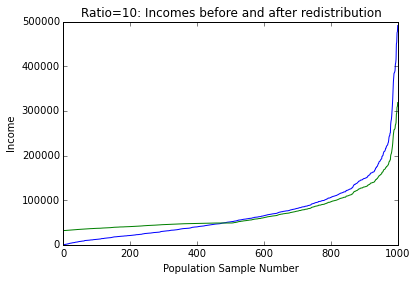

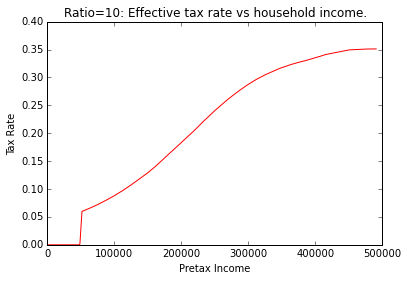

In [31]:
run_mirra(ratio=10)


Lows Before: [108, 117, 416, 442, 471, 590, 849, 1007, 1263, 1325]
Lows After: [21773, 21774, 21801, 21804, 21809, 21832, 21888, 21907, 21937, 21945]

Highs Before: [387112, 390481, 404757, 407521, 415736, 450036, 453488, 475202, 477215]
Highs After: [347832, 350653, 362585, 364899, 371644, 400455, 403367, 421930, 423659]


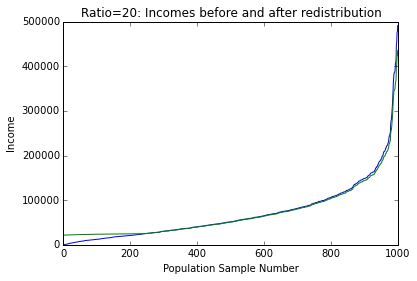

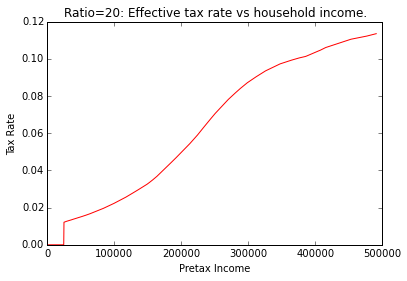

In [32]:
run_mirra(ratio=20)


Lows Before: [108, 117, 416, 442, 471, 590, 849, 1007, 1263, 1325]
Lows After: [9633, 9633, 9644, 9645, 9645, 9649, 9659, 9664, 9671, 9674]

Highs Before: [387112, 390481, 404757, 407521, 415736, 450036, 453488, 475202, 477215]
Highs After: [381151, 384404, 398217, 400890, 408789, 441880, 445216, 466176, 468149]


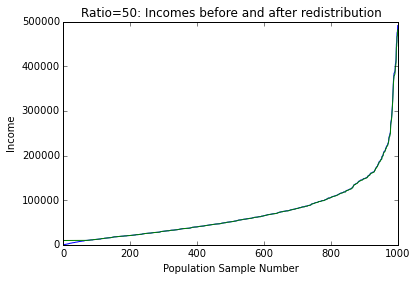

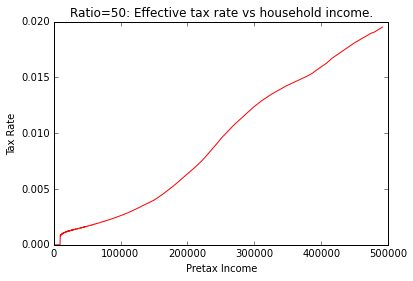

In [33]:
run_mirra(ratio=50)

Lows Before: [108, 117, 416, 442, 471, 590, 849, 1007, 1263, 1325]
Lows After: [4884, 4885, 4888, 4889, 4890, 4891, 4894, 4896, 4897, 4898]

Highs Before: [387112, 390481, 404757, 407521, 415736, 450036, 453488, 475202, 477215]
Highs After: [385501, 388840, 402982, 405719, 413841, 447754, 451167, 472687, 474680]


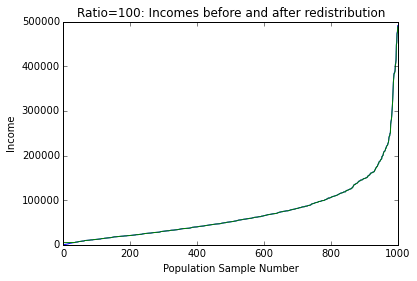

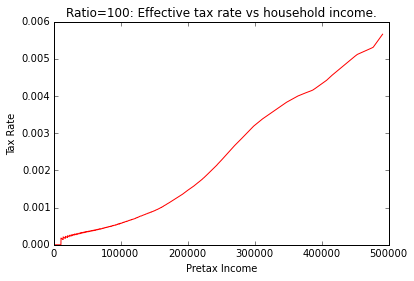

In [34]:
run_mirra(100)